In [118]:
# Import necessary libraries
import os
import numpy as np
import librosa
import librosa.display
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import IPython.display as ipd

# Path to speaker-info.txt
speaker_info_path = r".\\dataset\\speaker-info.txt"

# Function to read the speaker-info.txt file
def load_speaker_info(file_path):
    # Read the file line by line, skipping headers
    data = []
    with open(file_path, 'r') as f:
        lines = f.readlines()[1:]  # Skip the header
        for line in lines:
            parts = line.strip().split()  # Split by whitespace
            if len(parts) < 5:  # Handle cases with missing columns
                parts += [''] * (5 - len(parts))
            data.append(parts[:5])  # Keep only the first 5 columns

    # Create a DataFrame
    columns = ['ID', 'AGE', 'GENDER', 'ACCENTS', 'REGION']
    return pd.DataFrame(data, columns=columns)

# Load the speaker information
speaker_info = load_speaker_info(speaker_info_path)

# Clean up the data
speaker_info['ID'] = speaker_info['ID'].str.strip()  # Clean ID
speaker_info['AGE'] = pd.to_numeric(speaker_info['AGE'], errors='coerce')  # Convert AGE to numeric
speaker_info['GENDER'] = speaker_info['GENDER'].str.strip()  # Clean GENDER

print("Speaker Info loaded:")
print(speaker_info.head())



Speaker Info loaded:
    ID  AGE GENDER  ACCENTS    REGION
0  225   23      F  English  Southern
1  226   22      M  English    Surrey
2  227   38      M  English   Cumbria
3  228   22      F  English  Southern
4  229   23      F  English  Southern


In [119]:
# Corrected path to the wav48 directory
wav_path = r".\\dataset\\wav48"

# Ensure speaker IDs are formatted correctly (e.g., with the 'p' prefix)
speaker_ids = speaker_info['ID'].tolist()
speaker_ids = [f"p{id}" for id in speaker_ids]  # Add 'p' prefix to speaker IDs

# Function to load audio files by speaker
def load_audio_files_by_speaker(speaker_list, num_sentences_per_speaker, wav_path):
    audio_data = []
    for speaker in speaker_list:
        speaker_folder = os.path.join(wav_path, speaker)
        if not os.path.exists(speaker_folder):
            print(f"Speaker folder not found: {speaker_folder}")
            continue
        # Load `.wav` files for this speaker
        wav_files = sorted([f for f in os.listdir(speaker_folder) if f.endswith('.wav')])[:num_sentences_per_speaker]
        for wav_file in wav_files:
            file_path = os.path.join(speaker_folder, wav_file)
            y, sr = librosa.load(file_path, sr=16000)  # Resample to 16kHz
            audio_data.append(y)
    return audio_data

# Split speakers into train, val, and test sets
np.random.seed(42)
np.random.shuffle(speaker_ids)

train_speakers = speaker_ids[:80]
val_speakers = speaker_ids[80:100]
test_speakers = speaker_ids[100:120]

# Load audio data
train_audio = load_audio_files_by_speaker(train_speakers, num_sentences_per_speaker=10, wav_path=wav_path)
val_audio = load_audio_files_by_speaker(val_speakers, num_sentences_per_speaker=10, wav_path=wav_path)
test_audio = load_audio_files_by_speaker(test_speakers, num_sentences_per_speaker=10, wav_path=wav_path)

print(f"Loaded {len(train_audio)} training audio samples.")
print(f"Loaded {len(val_audio)} validation audio samples.")
print(f"Loaded {len(test_audio)} testing audio samples.")


Loaded 800 training audio samples.
Loaded 200 validation audio samples.
Loaded 80 testing audio samples.


In [120]:
# Path to noise directory
noise_path = r".\\dataset\\Noise"

# Function to load noise files
def load_noise_files(noise_path):
    noise_files = [f for f in os.listdir(noise_path) if f.endswith('.wav')]
    noise_list = []
    for noise_file in noise_files:
        file_path = os.path.join(noise_path, noise_file)
        y, sr = librosa.load(file_path, sr=16000)
        noise_list.append(y)
    return noise_list

# Load noise files
noise_list = load_noise_files(noise_path)
print(f"Loaded {len(noise_list)} noise files.")


Loaded 10 noise files.


In [121]:
# Function to add noise and compute features/masks
def add_noise_and_generate_features(audio_list, noise_list, sr=16000, n_mels=64, snr_levels=[-5, 0, 5]):
    features = []
    masks = []
    for audio in audio_list:
        # Select a random noise and apply SNR
        noise = noise_list[np.random.randint(len(noise_list))]
        audio_length = len(audio)
        if len(noise) >= audio_length:
            noise = noise[:audio_length]
        else:
            noise = np.pad(noise, (0, audio_length - len(noise)), 'wrap')

        # Scale noise to desired SNR
        snr_db = np.random.choice(snr_levels)
        snr_linear = 10 ** (snr_db / 20)
        rms_audio = np.sqrt(np.mean(audio ** 2))
        rms_noise = np.sqrt(np.mean(noise ** 2))
        noise = noise * (rms_audio / (snr_linear * rms_noise))

        # Generate noisy audio
        noisy_audio = audio + noise

        # Extract features
        S_clean = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
        S_noisy = librosa.feature.melspectrogram(y=noisy_audio, sr=sr, n_mels=n_mels)
        irm = S_clean / (S_noisy + 1e-8)

        features.append(librosa.power_to_db(S_noisy).T)
        masks.append(irm.T)
    return features, masks

# Generate features and masks for train, val, and test sets
train_features, train_masks = add_noise_and_generate_features(train_audio, noise_list)
val_features, val_masks = add_noise_and_generate_features(val_audio, noise_list)
test_features, test_masks = add_noise_and_generate_features(test_audio, noise_list)

print(f"Generated {len(train_features)} training features and masks.")


Generated 800 training features and masks.


In [122]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, BatchNormalization

# Define the CNN model
input_shape = (128, 64, 1)  # Based on spectrogram dimensions
inputs = Input(shape=input_shape)

# CNN layers
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Flatten()(x)

# Fully connected layers
x = Dense(512, activation='relu')(x)
x = Dense((input_shape[0] // 8) * (input_shape[1] // 8) * 128, activation='relu')(x)
x = Reshape((input_shape[0] // 8, input_shape[1] // 8, 128))(x)

# Transpose layers to restore original dimensions
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Build and compile the CNN model
model = Model(inputs, outputs, name="TransientNoiseReductionCNN")
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

model.summary()


Model: "TransientNoiseReductionCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128, 64, 1)]      0         
                                                                 
 conv2d_44 (Conv2D)          (None, 128, 64, 32)       320       
                                                                 
 batch_normalization_24 (Bat  (None, 128, 64, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 64, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 64, 32, 64)        18496     
                                                                 
 batch_normalization_25 (Bat  (None, 64,

In [123]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Function to pad or truncate features to a fixed shape
def pad_features(features, target_shape=(128, 64)):
    padded_features = []
    for feature in features:
        # Truncate or pad each spectrogram to the target shape
        padded = librosa.util.fix_length(feature, size=target_shape[0], axis=0)  # Pad time dimension
        padded = librosa.util.fix_length(padded, size=target_shape[1], axis=1)  # Pad frequency dimension
        padded_features.append(padded)
    return np.array(padded_features)

# Pad features and masks
target_shape = (128, 64)  # Adjust target shape as needed
train_features = pad_features(train_features, target_shape)
val_features = pad_features(val_features, target_shape)
test_features = pad_features(test_features, target_shape)

train_masks = pad_features(train_masks, target_shape)
val_masks = pad_features(val_masks, target_shape)
test_masks = pad_features(test_masks, target_shape)

# Add channel dimension for CNNs
train_features = np.expand_dims(train_features, -1)
val_features = np.expand_dims(val_features, -1)
test_features = np.expand_dims(test_features, -1)



In [124]:
# Prepare features for training
train_features = np.expand_dims(train_features, -1)
val_features = np.expand_dims(val_features, -1)
test_features = np.expand_dims(test_features, -1)

# Train the model
history = model.fit(
    np.array(train_features), np.array(train_masks),
    validation_data=(np.array(val_features), np.array(val_masks)),
    epochs=5,
    batch_size=32
)

# Evaluate the model on test data
loss = model.evaluate(np.array(test_features), np.array(test_masks))
print(f"Test Loss: {loss}")


Epoch 1/5
25/25 [==============================] - 20s 786ms/step - loss: 0.1420 - val_loss: 0.5848
Epoch 2/5
25/25 [==============================] - 19s 777ms/step - loss: 0.0899 - val_loss: 0.3096
Epoch 3/5
25/25 [==============================] - 19s 752ms/step - loss: 0.0756 - val_loss: 0.1389
Epoch 4/5
25/25 [==============================] - 25s 1s/step - loss: 0.0702 - val_loss: 0.0748
Epoch 5/5
3/3 [==============================] - 0s 119ms/step - loss: 0.0704
Test Loss: 0.07038390636444092


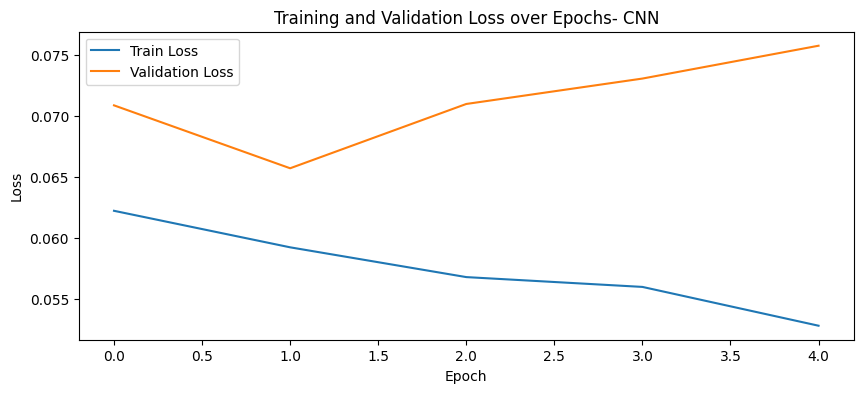

In [131]:
# Plot Training History
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs- CNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

5/5 [==============================] - 1s 131ms/step - loss: 0.0704
Test Loss (MSE): 0.070384
1/1 [==============================] - 0s 364ms/step


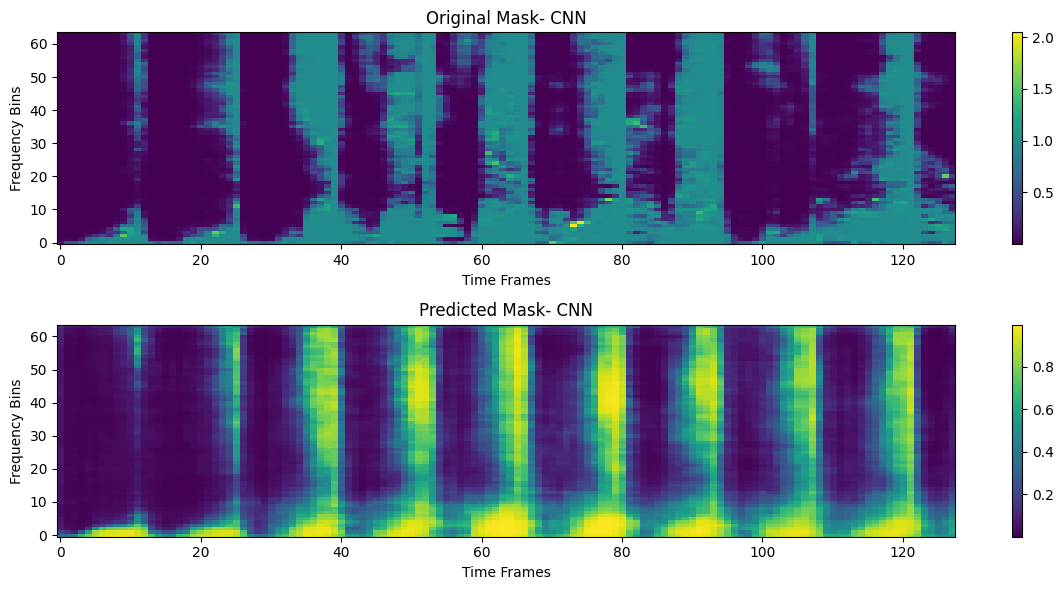

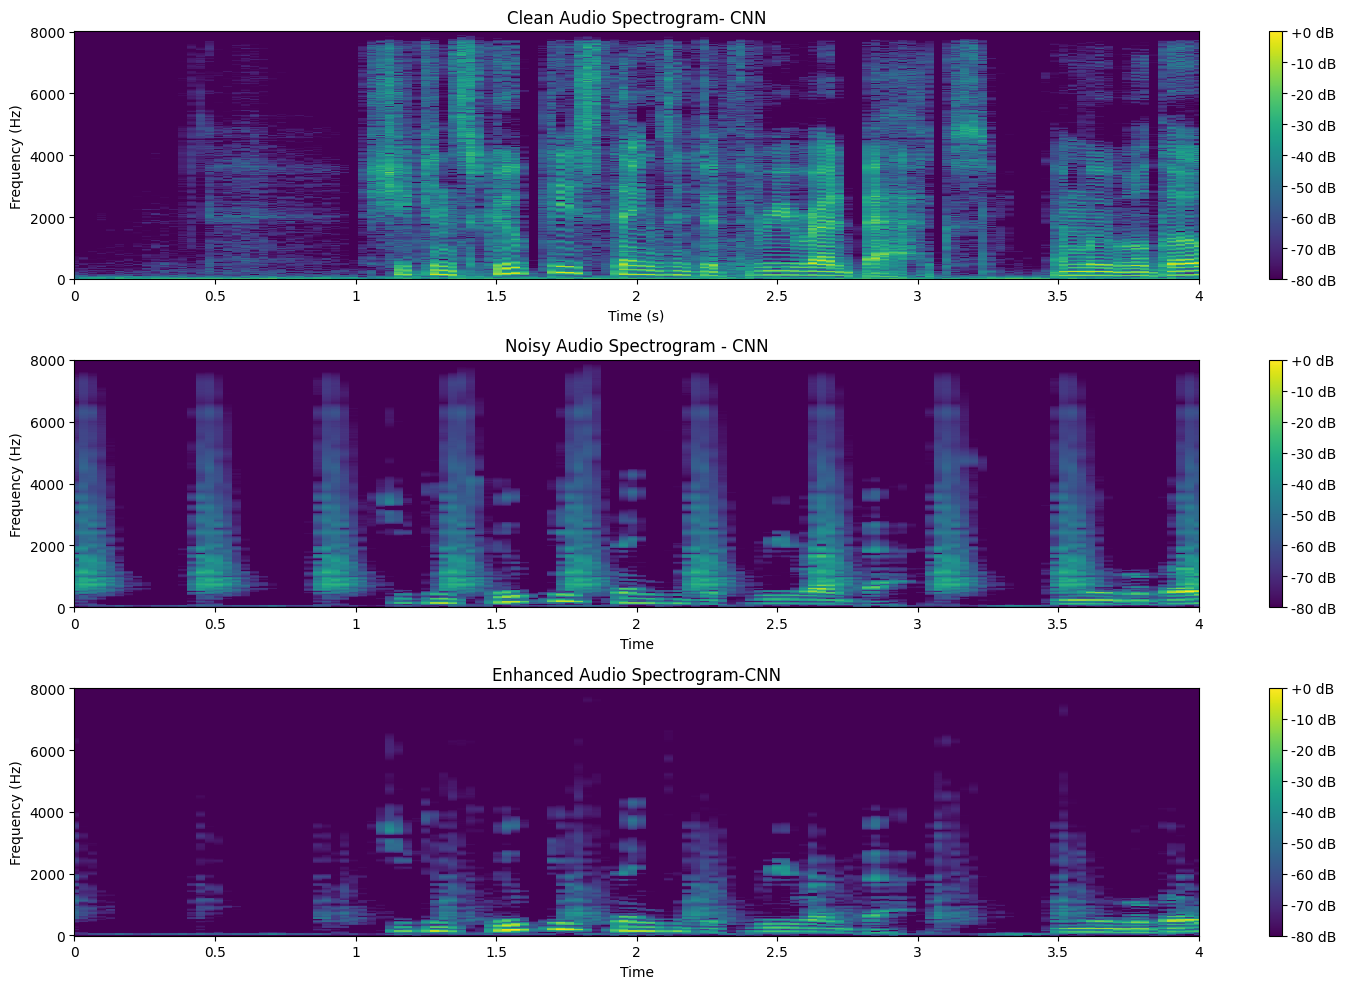

Original Noisy Audio:


Enhanced Audio:


Clean Audio:


In [126]:
# Evaluate the model on the testing set
test_loss = model.evaluate(test_features, test_masks, batch_size=16)  # Adjust batch_size if needed
print(f"Test Loss (MSE): {test_loss:.6f}")

# Select a test sample
test_sample_index = 3  # Change this index to test different samples
test_sample = test_features[test_sample_index:test_sample_index + 1]
test_mask = test_masks[test_sample_index:test_sample_index + 1]

# Predict the mask
predicted_mask = model.predict(test_sample)

import matplotlib.pyplot as plt

# Visualize the original mask and predicted mask
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.title('Original Mask- CNN')
plt.imshow(test_mask.squeeze().T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar()
plt.xlabel('Time Frames')
plt.ylabel('Frequency Bins')

plt.subplot(2, 1, 2)
plt.title('Predicted Mask- CNN')
plt.imshow(predicted_mask.squeeze().T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar()
plt.xlabel('Time Frames')
plt.ylabel('Frequency Bins')

plt.tight_layout()
plt.show()

import librosa

# Get the noisy spectrogram for the test sample
noisy_spectrogram = test_sample.squeeze().T  # Shape: (n_mels, time_steps)

# Convert back from dB to power
noisy_spectrogram_power = librosa.db_to_power(noisy_spectrogram)

# Apply the predicted mask
enhanced_spectrogram_power = noisy_spectrogram_power * predicted_mask.squeeze().T

# Reconstruct the enhanced audio
enhanced_audio = librosa.feature.inverse.mel_to_audio(
    enhanced_spectrogram_power,
    sr=16000,
    n_fft=1024,
    hop_length=512,
    power=1.0,
    n_iter=32,
)

# Original noisy audio for comparison
# Reconstruct the noisy audio from the spectrogram
noisy_audio = librosa.feature.inverse.mel_to_audio(
    noisy_spectrogram_power,
    sr=16000,
    n_fft=1024,
    hop_length=512,
    power=1.0,
    n_iter=32,
)

# Compute spectrograms
# Noisy audio spectrogram
noisy_S = librosa.stft(noisy_audio, n_fft=1024, hop_length=512)
noisy_S_db = librosa.amplitude_to_db(np.abs(noisy_S), ref=np.max)

# Enhanced audio spectrogram
enhanced_S = librosa.stft(enhanced_audio, n_fft=1024, hop_length=512)
enhanced_S_db = librosa.amplitude_to_db(np.abs(enhanced_S), ref=np.max)

# Clean audio spectrogram
clean_S = librosa.stft(clean_audio, n_fft=1024, hop_length=512)
clean_S_db = librosa.amplitude_to_db(np.abs(clean_S), ref=np.max)

# Plotting
plt.figure(figsize=(15, 10))

# Clean Audio Spectrogram
plt.subplot(3, 1, 1)
librosa.display.specshow(clean_S_db, sr=16000, hop_length=512, x_axis='time', y_axis='hz', cmap='viridis')
plt.title('Clean Audio Spectrogram- CNN')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.xlim(0, 4)

# Noisy Audio Spectrogram
plt.subplot(3, 1, 2)
librosa.display.specshow(noisy_S_db, sr=16000, hop_length=512, x_axis='time', y_axis='hz', cmap='viridis')
plt.title('Noisy Audio Spectrogram - CNN')
plt.colorbar(format='%+2.0f dB')
plt.ylabel('Frequency (Hz)')
plt.xlim(0, 4)

# Enhanced Audio Spectrogram
plt.subplot(3, 1, 3)
librosa.display.specshow(enhanced_S_db, sr=16000, hop_length=512, x_axis='time', y_axis='hz', cmap='viridis')
plt.title('Enhanced Audio Spectrogram-CNN')
plt.colorbar(format='%+2.0f dB')
plt.ylabel('Frequency (Hz)')
plt.xlim(0, 4)

plt.tight_layout()
plt.show()




# Clean audio for reference
# Since we have the original clean audio, we can use it directly
clean_audio = test_audio[test_sample_index]

from IPython.display import Audio, display

print("Original Noisy Audio:")
display(Audio(noisy_audio, rate=16000))

print("Enhanced Audio:")
display(Audio(enhanced_audio, rate=16000))

print("Clean Audio:")
display(Audio(clean_audio, rate=16000))


In [128]:
from sklearn.metrics import mean_squared_error
from pystoi import stoi
from pesq import pesq  # For PESQ computation
import numpy as np

# Function to normalize signals
def normalize_signal(signal):
    return signal / np.max(np.abs(signal))

# Function to compute SNR
def compute_snr(clean_signal, processed_signal):
    """
    Compute Signal-to-Noise Ratio (SNR).
    """
    min_len = min(len(clean_signal), len(processed_signal))
    clean_signal = clean_signal[:min_len]
    processed_signal = processed_signal[:min_len]
    
    # Normalize signals
    clean_signal = normalize_signal(clean_signal)
    processed_signal = normalize_signal(processed_signal)

    # Signal and noise power
    signal_power = np.sum(clean_signal ** 2)
    noise_power = np.sum((clean_signal - processed_signal) ** 2)
    snr = 10 * np.log10(signal_power / (noise_power + 1e-8))
    return snr

# Ensure all signals have the same length
min_len = min(len(clean_audio), len(noisy_audio), len(enhanced_audio))
clean_audio = clean_audio[:min_len]
noisy_audio = noisy_audio[:min_len]
enhanced_audio = enhanced_audio[:min_len]

# Normalize signals
clean_audio = normalize_signal(clean_audio)
noisy_audio = normalize_signal(noisy_audio)
enhanced_audio = normalize_signal(enhanced_audio)

# Compute SNR for Noisy and Enhanced audio
snr_noisy = compute_snr(clean_audio, noisy_audio)
snr_enhanced = compute_snr(clean_audio, enhanced_audio)
snr_improvement = snr_enhanced - snr_noisy

# Compute PESQ Score
pesq_score = pesq(16000, clean_audio, enhanced_audio, 'wb')

# Compute Mean Squared Error (MSE)
mse = mean_squared_error(clean_audio, enhanced_audio)

# Compute STOI Score
stoi_score = stoi(clean_audio, enhanced_audio, 16000, extended=False)

# Print Results
print(f"SNR of Noisy Audio: {snr_noisy:.2f} dB")
print(f"SNR of Enhanced Audio: {snr_enhanced:.2f} dB")
print(f"SNR Improvement: {snr_improvement:.2f} dB")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"PESQ Score: {pesq_score:.2f}")
print(f"STOI Score: {stoi_score:.2f}")


SNR of Noisy Audio: -1.96 dB
SNR of Enhanced Audio: -1.70 dB
SNR Improvement: 0.26 dB
Mean Squared Error (MSE): 0.020521
PESQ Score: 1.15
STOI Score: 0.49


In [129]:
import time
from memory_profiler import memory_usage
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from pystoi import stoi
from pesq import pesq
import numpy as np

# 1. Measure Training Time
start_time = time.time()

history = model.fit(
    train_features, train_masks,
    validation_data=(val_features, val_masks),
    epochs=5,  # Example value
    batch_size=32  # Example value
)

training_time = time.time() - start_time
print(f"Total Training Time: {training_time:.2f} seconds")

# 2. Measure Inference Time
start_time = time.time()
predicted_mask = model.predict(test_features[0:1])  # Single test sample
inference_time = time.time() - start_time
print(f"Inference Time for one sample: {inference_time:.4f} seconds")

# 3. Measure Memory Usage
def train_model():
    model.fit(
        train_features, train_masks,
        validation_data=(val_features, val_masks),
        epochs=5,  # Single epoch for memory profiling
        batch_size=32  # Example value
    )

mem_usage = memory_usage(train_model)
memory_consumption = max(mem_usage) - min(mem_usage)
print(f"Maximum Memory Usage during Training: {memory_consumption:.2f} MiB")

# 4. Evaluate Performance Metrics
test_loss = model.evaluate(test_features, test_masks)
print(f"Test Loss (MSE): {test_loss:.6f}")


Epoch 1/5
25/25 [==============================] - 24s 952ms/step - loss: 0.0622 - val_loss: 0.0709
Epoch 2/5
25/25 [==============================] - 22s 884ms/step - loss: 0.0592 - val_loss: 0.0657
Epoch 3/5
25/25 [==============================] - 22s 894ms/step - loss: 0.0568 - val_loss: 0.0710
Epoch 4/5
25/25 [==============================] - 22s 880ms/step - loss: 0.0560 - val_loss: 0.0731
Epoch 5/5
25/25 [==============================] - 23s 918ms/step - loss: 0.0528 - val_loss: 0.0757
Total Training Time: 113.14 seconds
1/1 [==============================] - 0s 58ms/step
Inference Time for one sample: 0.0896 seconds
Epoch 1/5
25/25 [==============================] - 22s 877ms/step - loss: 0.0497 - val_loss: 0.0691
Epoch 2/5
25/25 [==============================] - 22s 884ms/step - loss: 0.0463 - val_loss: 0.0617
Epoch 3/5
25/25 [==============================] - 24s 971ms/step - loss: 0.0444 - val_loss: 0.0699
Epoch 4/5
25/25 [==============================] - 22s 868ms/step 


Performance and Computational Cost Metrics:
Training Time (s): 113.1374
Inference Time (s): 0.0896
Memory Usage (MiB): 301.6953
Test Loss (MSE): 0.0611
SNR Improvement (dB): 0.2619
Mean Squared Error: 0.020520763471722603
PESQ Score: 1.1497
STOI Score: 0.4858


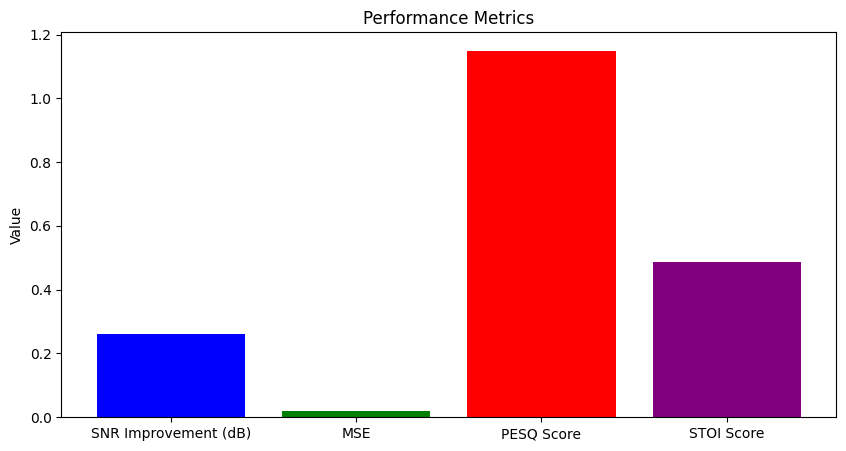

In [130]:

# Create a summary table
metrics_summary = {
    'Training Time (s)': training_time,
    'Inference Time (s)': inference_time,
    'Memory Usage (MiB)': memory_consumption,
    'Test Loss (MSE)': test_loss,
    'SNR Improvement (dB)': snr_improvement,
    'Mean Squared Error': mse,
    'PESQ Score': pesq_score,
    'STOI Score': stoi_score
}

# Display the metrics
print("\nPerformance and Computational Cost Metrics:")
for key, value in metrics_summary.items():
    print(f"{key}: {value:.4f}" if isinstance(value, float) else f"{key}: {value}")

# 5. Visualize Performance Metrics
performance_metrics = ['SNR Improvement (dB)', 'MSE', 'PESQ Score', 'STOI Score']
performance_values = [snr_improvement, mse, pesq_score, stoi_score]

plt.figure(figsize=(10, 5))
plt.bar(performance_metrics, performance_values, color=['blue', 'green', 'red', 'purple'])
plt.title('Performance Metrics')
plt.ylabel('Value')
plt.show()
